In [1]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
class GanglionCellResponse(ec2b.TemporalModel):
    def __init__(self, tsample):
        super(GanglionCellResponse, self).__init__(tsample)
        
    def stationary_nonlinearity(self, resp):
        return resp
    
    def slow_response(self, resp):
        return resp

In [3]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [4]:
# Monophasic pulse
def get_monophasic_pulse(pulse_dur, stim_dur, freq, amp, tsample, ptype='cathodic', delay_dur=0.01):
    assert pulse_dur > 0
    assert stim_dur > 0
    assert delay_dur > 0
    
    stim_size = int(round(stim_dur / tsample))
    if amp == 0 or freq == 0:
        return TimeSeries(tsample, np.zeros(stim_size))

    pulse_size = int(round(pulse_dur / tsample))
    envelope_size = int(round(1.0 / float(freq) / tsample))
    delay_size = int(round(delay_dur / tsample))
    assert pulse_size <= envelope_size
    assert pulse_size <= stim_size
    
    pulse = np.ones(pulse_size)
    if ptype == 'cathodic':
        pulse *= -amp
    elif ptype == 'anodic':
        pulse *= amp
    else:
        raise ValueError("Unknown `ptype` '" + ptype + "'")
    gap = np.zeros(envelope_size - pulse_size)
    
    pulse_train = np.array([])
    for j in range(int(np.ceil(stim_dur * freq))):
        pulse_train = np.concatenate((pulse_train, pulse, gap), axis=0)
        
    delay = np.zeros(delay_size)
    pulse_train = np.concatenate((delay, pulse_train), axis=0)
    pulse_train = pulse_train[:stim_size]
    
    return TimeSeries(tsample, pulse_train)

(-5000, 20000)

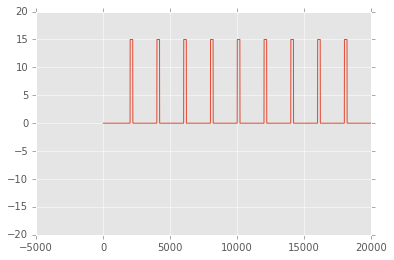

In [5]:
pt = get_monophasic_pulse(1.0 / 1000, 100.0 / 1000, 100, 15, 0.005 / 1000, 'anodic')
plt.plot(pt.data)
plt.ylim(-20, 20)
plt.xlim(-5000, 20000)

In [6]:
# Electrode-retina distances used in experiments (um)
heights = np.array([0, 50, 100, 150, 200, 300, 400])

In [7]:
# Stimulating electrodes: disc-shaped, 125um and 500um diameter, electrode-retina distance unknown
e125 = e2cm.ElectrodeArray('epiretinal', 125.0 / 2, -500, -500, heights[0], 'E125')
e500 = e2cm.ElectrodeArray('epiretinal', 500.0 / 2, -500, -500, heights[0], 'E500')

In [8]:
# Create a retina
r_sampling = 100       # spatial sampling of retina
axon_lambda = 2        # constant that determines fall-off with axonal distance
rot = 0 * np.pi / 180  # retina rotation angle
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=rot,
                     xlo=-500, xhi=-500, ylo=-500, yhi=-500)

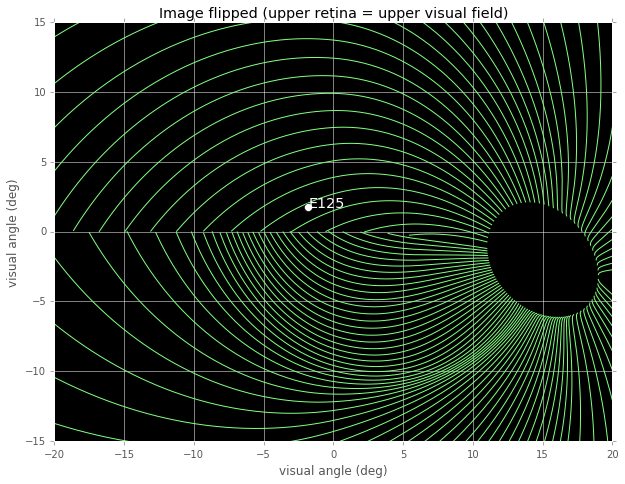

In [9]:
from matplotlib import patches

# Plot axon bundles (plot every 5th for the sake of visualization)
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.set_axis_bgcolor('black')
ax.plot(retina.jan_x[:, ::5], -retina.jan_y[:, ::5], c=(0.5, 1, 0.5))

# Draw in the the retinal patch we're simulating.
# This defines the size of our "percept" image below.
ax.add_patch(patches.Rectangle((e2cm.micron2deg(retina.gridx.min()), 
                                -e2cm.micron2deg(retina.gridy.max())),
                               e2cm.micron2deg(retina.gridx.max() - retina.gridx.min()),
                               e2cm.micron2deg(retina.gridy.max() - retina.gridy.min()),
                               alpha=0.7))

# Plot all electrodes and their label
for e in e125.electrodes:
    ax.text(e2cm.micron2deg(e.x_center + 10), -e2cm.micron2deg(e.y_center + 5), e.name,
            color='white', size='x-large')
    ax.plot(e2cm.micron2deg(e.x_center), -e2cm.micron2deg(e.y_center), 'ow',
            markersize=np.sqrt(e.radius))

ax.set_aspect('equal')
ax.set_xlim(-20, 20)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-15, 15)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')

In [10]:
# Data extracted from Fig. 3a in Jensen et al. (2005)
# Axons
jensen_125_axon = np.array([0.10000, 2.99614, 0.19835, 1.59634, 0.49824, 0.72339, 1.00000, 0.54247,
                           2.00708, 0.48697, 5.04155, 0.46555, 10.00000, 0.46976, 20.30918, 0.46976,
                           50.41550, 0.46555]).reshape((-1, 2))
jensen_125_axon[:, 0] /= 1000.0

jensen_500_axon = np.array([0.09883, 20.86371, 0.19535, 8.69288, 0.48840, 4.50809, 0.98832, 2.93549,
                            1.90815, 2.31750, 4.88400, 2.19890, 9.54095, 2.08637, 19.08149, 2.06818,
                            47.70583, 1.99701]).reshape((-1, 2))
jensen_500_axon[:, 0] /= 1000.0


# LL cells
# The LL cell responses consisted of one or more bursts of typically two to five action potentials
# after stimulation at or slightly above threshold current. Unlike the SL cell responses, the
# LL cell responses did not appear to be due to direct activation of RGCs but rather to
# presynaptic activation of retinal neurons.
# LL (delayed) responses have higher thresholds than SL (immediate) responses.
jensen_125_ll = np.array([0.09767, 15.26138, 0.19835, 9.13982, 0.49824, 4.78286, 0.98826, 3.02321,
                         1.96023, 2.01691, 4.92388, 0.93057, 10.00000, 0.67317, 19.60233, 0.35227,
                         49.82369, 0.28133]).reshape((-1, 2))
jensen_125_ll[:, 0] /= 1000.0

jensen_500_ll = np.array([0.09883, 53.70788, 0.20000, 36.53740, 0.48840, 12.23073, 0.96537, 8.76932,
                          1.90815, 6.39858, 4.88400, 4.13019, 9.65370, 2.46397, 19.08149, 1.81366,
                          47.70583, 0.96559]).reshape((-1, 2))
jensen_500_ll[:, 1] /= 1000.0


# SL cells
# The SL cell responses were typically a single action potential, although a few cells elicited
# a second action potential that immediately followed the first.
jensen_125_sl = np.array([0.10239, 0.74318, 0.19372, 0.62082, 0.49824, 0.46976, 1.00000, 0.37855,
                         1.96023, 0.39954, 5.04155, 0.40679, 10.00000, 0.39954, 19.83517, 0.39242, 
                         49.82369, 0.35866]).reshape((-1, 2))
jensen_125_sl[:, 0] /= 1000.0

jensen_500_sl = np.array([0.09883, 6.86281, 0.20000, 4.50809, 0.47706, 2.83447, 0.98832, 2.01457,
                          1.93070, 2.05016, 4.77058, 1.99701, 9.54095, 2.01457, 19.08149, 1.97960,
                          47.14866, 1.87830]).reshape((-1, 2))
jensen_500_sl[:, 0] /= 1000.0

In [11]:
def run_fig3(implant, retina, amp_th, use_ecs):
    tsample = 0.005 / 1000
    stim_dur = 0.5
    stim_freq = 2
    amp_in = [0.1, 10]
    
    # Don't execute the full model cascade: We're interested in RGC-like responses
    tm = GanglionCellResponse(tsample=tsample)
    
    # Pulse durations used in experiments (seconds)
    pulse_durs = np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]) / 1000

    # We need to define some activity value that corresponds to threshold activity.
    # We do this by executing the model at the first data point of the Jensen paper.
    # Whatever activity is produced by these parameters, we'll take as threshold
    # activity, and will try to find the matching current for all subsequent data points
    stim = get_monophasic_pulse(pulse_durs[0], stim_dur, stim_freq, amp_th, tsample)
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=use_ecs, engine='joblib', tol=0.2
                            verbose=False)
#     mov.data = mov.data[2:-3, 2:-3, :]
    act_match = mov.data.max()
    print('Threshold: amp_in=%f act_out=%f' % (amp_th, act_match))

    amp_match = []
    for pd in pulse_durs:
        print('Processing pulse dur %f' % pd)
        act_out = []
        for amp in amp_in:
            stim = get_monophasic_pulse(pd, stim_dur, stim_freq, amp, tsample)
            mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=use_ecs, engine='joblib',
                                     tol=0.2, verbose=False)
#             mov.data = mov.data[2:-3, 2:-3, :]
            act_out.append(mov.data.max())
        amp_match.append(fit_amps(amp_in, act_out, act_match))
        
    return pulse_durs, amp_match

In [12]:
# Generate data for axon plot
pulse_durs_axon, model_125_axon = run_fig3(e125, retina, jensen_125_axon[0, 1], True)

tol=20.00%, 1/1 pixels selected
Threshold: amp_in=2.996140 act_out=0.500325
Processing pulse dur 0.000100
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.000200
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.000500
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.001000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.002000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.005000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.010000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.020000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.050000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected


In [13]:
# Generate data for SL plot
pulse_durs_sl, model_125_sl = run_fig3(e125, retina, jensen_125_sl[0, 1], False)

tol=20.00%, 1/1 pixels selected
Threshold: amp_in=0.743180 act_out=0.124104
Processing pulse dur 0.000100
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.000200
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.000500
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.001000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.002000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.005000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.010000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.020000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.050000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected


In [14]:
# Generate data for axon plot
pulse_durs_axon, model_500_axon = run_fig3(e500, retina, jensen_500_axon[0, 1], True)

tol=20.00%, 1/1 pixels selected
Threshold: amp_in=20.863710 act_out=3.484028
Processing pulse dur 0.000100
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.000200
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.000500
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.001000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.002000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.005000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.010000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.020000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.050000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected


In [15]:
# Generate data for SL plot
pulse_durs_sl, model_500_sl = run_fig3(e500, retina, jensen_500_sl[0, 1], False)

tol=20.00%, 1/1 pixels selected
Threshold: amp_in=6.862810 act_out=1.146020
Processing pulse dur 0.000100
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.000200
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.000500
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.001000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.002000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.005000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.010000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.020000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected
Processing pulse dur 0.050000
tol=20.00%, 1/1 pixels selected
tol=20.00%, 1/1 pixels selected


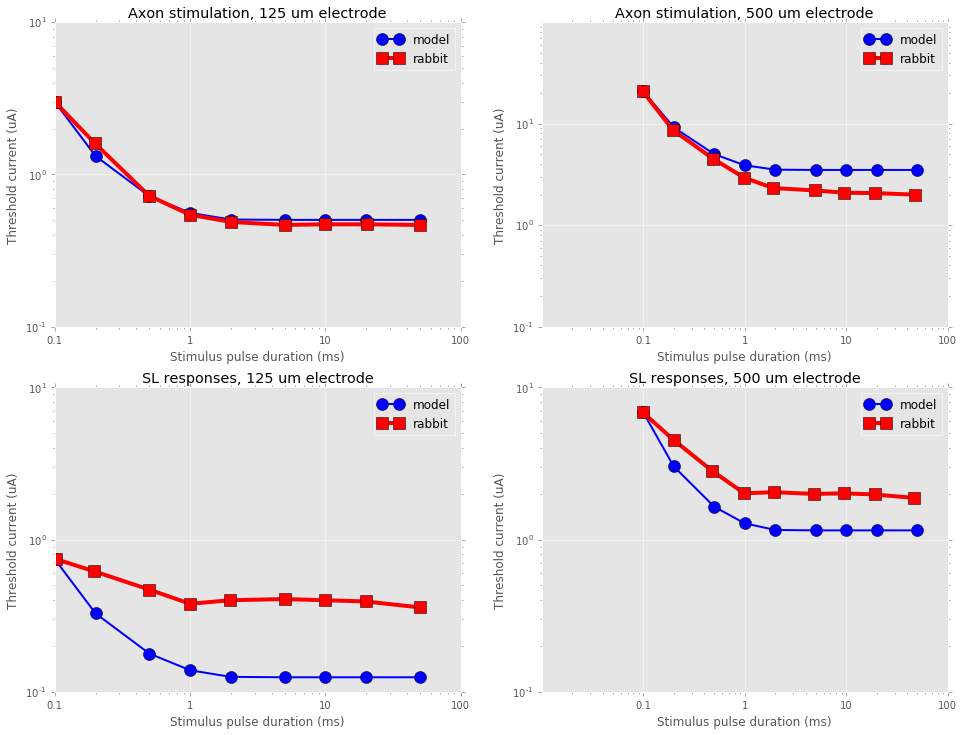

In [16]:
plt.figure(figsize=(16, 12))

plt.subplot(221)
plt.loglog(pulse_durs_axon, model_125_axon, 'o-b', linewidth=2, markersize=12, label='model')
plt.loglog(jensen_125_axon[:, 0], jensen_125_axon[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0.1, 1, 10, 100]) / 1000, [0.1, 1, 10, 100])
plt.yticks([0.1, 1, 10])
plt.xlabel('Stimulus pulse duration (ms)')
plt.ylabel('Threshold current (uA)')
plt.title('Axon stimulation, 125 um electrode')
plt.legend()

plt.subplot(222)
plt.loglog(pulse_durs_axon, model_500_axon, 'o-b', linewidth=2, markersize=12, label='model')
plt.loglog(jensen_500_axon[:, 0], jensen_500_axon[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0.1, 1, 10, 100]) / 1000, [0.1, 1, 10, 100])
plt.yticks([0.1, 1, 10])
plt.xlabel('Stimulus pulse duration (ms)')
plt.ylabel('Threshold current (uA)')
plt.title('Axon stimulation, 500 um electrode')
plt.legend()

plt.subplot(223)
plt.loglog(pulse_durs_sl, model_125_sl, 'o-b', linewidth=2, markersize=12, label='model')
plt.loglog(jensen_125_sl[:, 0], jensen_125_sl[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0.1, 1, 10, 100]) / 1000, [0.1, 1, 10, 100])
plt.yticks([0.1, 1, 10])
plt.xlabel('Stimulus pulse duration (ms)')
plt.ylabel('Threshold current (uA)')
plt.title('SL responses, 125 um electrode')
plt.legend()

plt.subplot(224)
plt.loglog(pulse_durs_sl, model_500_sl, 'o-b', linewidth=2, markersize=12, label='model')
plt.loglog(jensen_500_sl[:, 0], jensen_500_sl[:, 1], 's-r', linewidth=4, markersize=12, label='rabbit')
plt.xticks(np.array([0.1, 1, 10, 100]) / 1000, [0.1, 1, 10, 100])
plt.yticks([0.1, 1, 10])
plt.xlabel('Stimulus pulse duration (ms)')
plt.ylabel('Threshold current (uA)')
plt.title('SL responses, 500 um electrode')
plt.legend()
plt.savefig('jensen2005_fig3.eps')
plt.savefig('jensen2005_fig3.png')